In [1]:
%load_ext autoreload
%autoreload 2
import eval_models
import pandas as pd
import numpy as np
from boruta import BorutaPy
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['font.size'] = 25

### Lets try out mcfs on digits and its results
Note: the output is from R so we will have to transform it a little bit. The easiest is to open file in excel and delete ,class, at the end of each row

In [2]:
X_dig_train,X_dig_test,y_dig_train,y_dig_test=eval_models.get_train_test("digits")

In [3]:
x_times_mcfs=5
mcfs_all_results=pd.read_csv('../data/mcfs/digits-features.csv',header=None,sep="\n")
mcfs_all_results=mcfs_all_results.iloc[:,0].str.split(',', expand=True)
mcfs_all_array=np.array(list(filter(None,np.array(mcfs_all_results).flatten()))).astype(np.int64)

In [4]:
unique, counts=np.unique(mcfs_all_array,return_counts=True)
columns_mcfs= unique[counts>=x_times_mcfs*0.95]

In [5]:
#nie wiem czemu, ale iloc nie chciał działać
X_dig_train_mcfs_multiple=X_dig_train.loc[:,list(columns_mcfs)]
X_dig_train_mcfs_multiple.head()

,12,34,38,53,66,139,205,214,229,295,...,4917,4925,4933,4938,4947,4963,4966,4977,4980,4981
2868,0,0,987,332,980,0,0,658,960,0,...,0,563,987,0,740,0,0,972,0,770
4630,645,0,0,0,983,0,0,0,0,0,...,0,0,0,0,0,991,991,0,0,0
1870,0,801,987,976,980,980,980,987,0,976,...,0,976,0,976,0,0,0,0,0,0
353,877,0,529,0,987,886,983,693,0,987,...,983,0,999,527,779,991,968,991,0,937
3582,0,0,0,0,570,0,0,0,606,0,...,0,0,0,0,608,991,991,874,0,0


In [6]:
eval_models.get_models_ba(X_dig_train_mcfs_multiple,
                              X_dig_test,
                              y_dig_train,
                              y_dig_test,
                          n_estimators=250
                             )

LogisticRegression 0.9493
RandomForestClassifier 0.9673
AdaBoostClassifier 0.9527
LGBMClassifier 0.978
XGBClassifier 0.9733
262  features in the dataset


,Classifier,BA score
0,LogisticRegression,0.949333
1,RandomForestClassifier,0.967333
2,AdaBoostClassifier,0.952667
3,LGBMClassifier,0.978000
4,XGBClassifier,0.973333


In [7]:
X_dig_train_scaled,X_dig_test_scaled=eval_models.standarize(X_dig_train,X_dig_test)
X_dig_train_scaled_mcfs_multiple=X_dig_train_scaled.loc[:,columns_mcfs]

In [8]:
res_mcfs_no_corr=eval_models.get_models_ba(X_dig_train_scaled_mcfs_multiple,
                              X_dig_test_scaled,
                              y_dig_train,
                              y_dig_test,
                          n_estimators=250
                             )
res_mcfs_no_corr['Corr']='No'

LogisticRegression 0.96
RandomForestClassifier 0.968
AdaBoostClassifier 0.9527
LGBMClassifier 0.9767
XGBClassifier 0.9733
262  features in the dataset


In [9]:
X_dig_train_scaled_mcfs_multiple_corr=eval_models.delete_corr(X_dig_train_scaled_mcfs_multiple)

In [10]:
res_boruta_yes_corr=eval_models.get_models_ba(X_dig_train_scaled_mcfs_multiple_corr,
                              X_dig_test_scaled,
                              y_dig_train,
                              y_dig_test,
                          n_estimators=250)
res_boruta_yes_corr['Corr']="Yes"

LogisticRegression 0.9607
RandomForestClassifier 0.9693
AdaBoostClassifier 0.9527
LGBMClassifier 0.9767
XGBClassifier 0.9733
247  features in the dataset


In [11]:
res_mcfs_all=pd.concat([res_mcfs_no_corr,res_boruta_yes_corr])
res_mcfs_all

,Classifier,BA score,Corr
0,LogisticRegression,0.960000,No
1,RandomForestClassifier,0.968000,No
2,AdaBoostClassifier,0.952667,No
3,LGBMClassifier,0.976667,No
4,XGBClassifier,0.973333,No
0,LogisticRegression,0.960667,Yes
1,RandomForestClassifier,0.969333,Yes
2,AdaBoostClassifier,0.952667,Yes
3,LGBMClassifier,0.976667,Yes
4,XGBClassifier,0.973333,Yes


In [12]:
res_mcfs_all.replace(to_replace=['LogisticRegression','RandomForestClassifier','AdaBoostClassifier','LGBMClassifier','XGBClassifier'],value=['Logistic Regression','Random Forest','AdaBoost','LightGBM','XGBoost'],inplace=True)

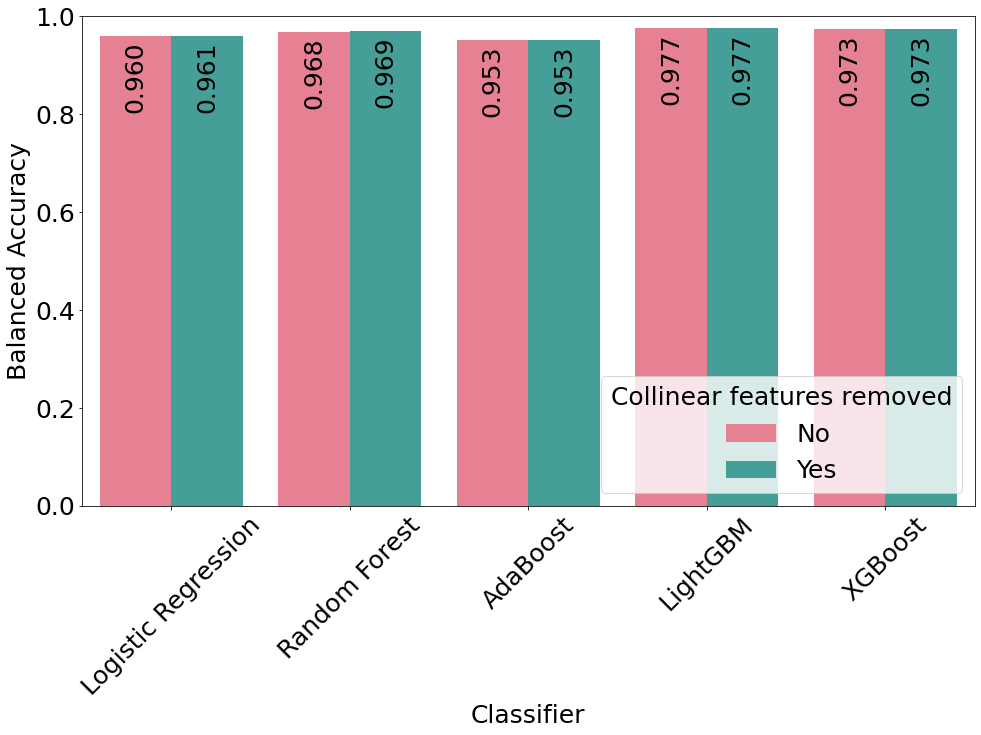

In [15]:
bars = sns.barplot(x='Classifier', y='BA score', hue='Corr', data=res_mcfs_all,palette=sns.color_palette("husl", 2))
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()-0.1), ha='center', va='center', xytext=(0, 8), rotation=90,
                   textcoords='offset points')
plt.ylim(0, 1)
plt.legend(loc=4, title='Collinear features removed')
plt.xlabel('Classifier')
plt.ylabel('Balanced Accuracy')
#plt.title('Digits\nClassifiers performance after Monte Carlo feature selection')
plt.xticks(rotation=45)
plt.show()